In [1]:
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from utils.plots import plot_km
from utils.data import get_chisq
import seaborn as sns
import pandas as pd


# surv data
surv_data = pd.read_csv("./data/gt_data.csv")
data_y = surv_data[["Status", "Survival_in_days"]].to_records(index=False)

surv_struct = np.array(
    list(zip(surv_data["Status"].to_list(), surv_data["Survival_in_days"].to_list())),
    dtype=[("Status", "?"), ("Survival_in_days", "<f8")],
)


# masks
def get_bool_mask(df_gt, df_ids):
    return np.array(df_gt["Sample_ID"].isin(df_ids))


train_mask = get_bool_mask(
    surv_data, pd.read_csv("./data/train_strat_id.csv")["Sample_ID"]
)
test_mask = get_bool_mask(
    surv_data, pd.read_csv("./data/test_strat_id.csv")["Sample_ID"]
)

train_max = surv_data[train_mask]["Survival_in_days"].max()
test_max = surv_data[test_mask]["Survival_in_days"].max()
test_min = surv_data[test_mask]["Survival_in_days"].min()

#### Baseline plots

In [2]:
from sklearn.manifold import TSNE

pam_labels = surv_data["Pam50 Subtype"]
latent = pd.read_csv("./data/latent_data.csv").iloc[:, 1:].values

latent = latent[test_mask]
pam_labels = pam_labels[test_mask].to_numpy()

# sns.set_theme(context="paper", style="white", font_scale=1.25)

idx = np.argsort(pam_labels)
latent = latent[idx]
pam_labels = pam_labels[idx]

z = TSNE(n_components=2, random_state=42).fit_transform(latent)

sns_plot = sns.scatterplot(
    x=z[:, 0],
    y=z[:, 1],
    hue=pam_labels,
    palette=sns.color_palette("bright", n_colors=4),
)

plt.savefig("./plots/latent_pam50_GT.jpg")
plt.close()

In [3]:
plot_km(surv_data["Survival_in_days"], surv_data["Status"], save_path="./plots/km_overall_survival.png")
plot_km(surv_data["Survival_in_days"][test_mask], surv_data["Status"][test_mask], surv_data["Pam50 Subtype"][test_mask], save_path="./plots/km_gt_pam50_test.png")

In [4]:
chi, p = get_chisq(surv_struct[test_mask], surv_data["Pam50 Subtype"][test_mask])
chi, p

(5.420064497820484, 0.14349858960500736)

In [5]:
total_test_samples = len(surv_data["Status"][test_mask])
uncensored_data = surv_data["Status"][test_mask].sum()
censored_data = total_test_samples-uncensored_data

uncensored_data/total_test_samples, censored_data/total_test_samples

(0.1485148514851485, 0.8514851485148515)

# Results

In [10]:
def combine_results(dict_best, path, finetuned_by, exp_type="test"):

    for id in os.listdir(path):
        model, n_edges, cls_type = id.split("_")

        dict_best["model"].append(model)
        dict_best["n_edges"].append(int(n_edges) if n_edges != "default" else 422)
        dict_best["cls_type"].append(cls_type)
        dict_best["finetuned_by"].append(finetuned_by)

        acc, f1, chi, p_value, test_chi, test_p_value = (
            pd.read_csv(os.path.join(path, id, exp_type, "cls_metrics.csv"))
            .values.flatten()
            .tolist()
        )

        dict_best["acc"].append(float(acc))
        dict_best["f1"].append(float(f1))
        dict_best["chi"].append(float(chi))
        dict_best["p"].append(float(p_value))
        dict_best["test_chi"].append(float(test_chi))
        dict_best["test_p"].append(float(test_p_value))


dict_best = {
    "model": [],
    "n_edges": [],
    "cls_type": [],
    "finetuned_by": [],
    "acc": [],
    "f1": [],
    "chi": [],
    "p": [],
    "test_chi": [],
    "test_p": [],
}

combine_results(dict_best, "./results/best_chi", "chi")
df = pd.DataFrame.from_dict(dict_best)
df["model"] = pd.Categorical(df["model"], ["MLP", "GCN", "GAT", "GATv2"])
df.sort_values(["n_edges", "model", "cls_type"], inplace=True)
df["significant"] = df["test_p"]<=0.05
df.to_csv("./results/all_cls_test_results.csv")
df

,model,n_edges,cls_type,finetuned_by,acc,f1,chi,p,test_chi,test_p,significant
28,MLP,0,MLP,chi,0.930693,0.933960,10.768100,0.013048,6.173010,0.103490,False
4,GCN,0,GNN,chi,0.900990,0.908088,13.570909,0.003551,6.008933,0.111176,False
9,GCN,0,MLP,chi,0.891089,0.900760,14.758474,0.002035,6.571688,0.086878,False
21,GAT,0,GNN,chi,0.910891,0.915550,11.862419,0.007870,6.056904,0.108874,False
19,GAT,0,MLP,chi,0.881188,0.893551,12.126668,0.006962,6.571688,0.086878,False
8,GATv2,0,GNN,chi,0.910891,0.915550,13.067994,0.004492,6.056904,0.108874,False
6,GATv2,0,MLP,chi,0.881188,0.883501,12.931319,0.004788,7.486399,0.057909,False
15,GCN,422,GNN,chi,0.891089,0.891279,17.457330,0.000569,8.933549,0.030188,True
16,GCN,422,MLP,chi,0.900990,0.898538,17.105124,0.000672,8.970103,0.029691,True
20,GAT,422,GNN,chi,0.891089,0.892965,14.008326,0.002894,7.733763,0.051847,False


### N_edges

/tmp/ipykernel_12108/995509059.py:7: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.pointplot(data=df_mlp, x="n_edges", y="f1", hue="model",palette=sns.color_palette("tab10"),estimator="max", dodge=True, errorbar=None, ax=axs[0])
/tmp/ipykernel_12108/995509059.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gnn["model"] = pd.Categorical(df_gnn["model"], ["GCN", "GAT", "GATv2"])
/tmp/ipykernel_12108/995509059.py:12: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.pointplot(data=df_gnn, x="n_edges", y="f1", hue="model",palette=sns.color_palette("tab10")[1:], estimator="max", dodge=True, errorbar=None, ax=axs[1])


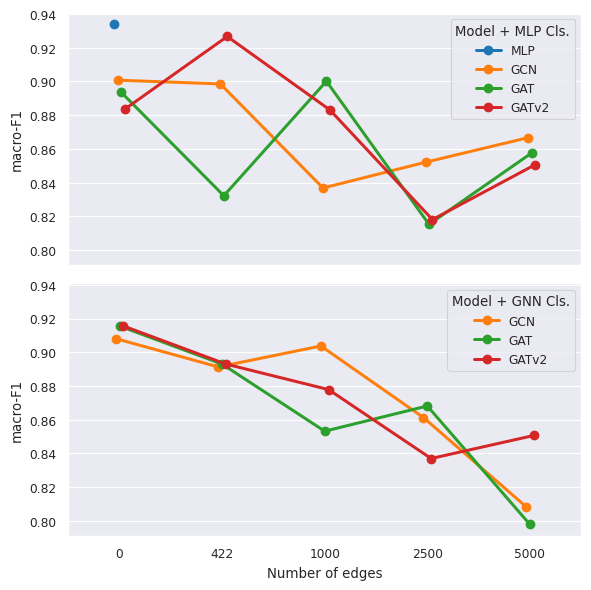

In [15]:
sns.set_theme(context='paper', style='darkgrid', palette=sns.color_palette())

fig, axs = plt.subplots(nrows=2, figsize=(6, 6), dpi=100, sharex=True, sharey=True)
plt.xlabel("Number of edges")

df_mlp = df[df["cls_type"]=="MLP"]
sns.pointplot(data=df_mlp, x="n_edges", y="f1", hue="model",palette=sns.color_palette("tab10"),estimator="max", dodge=True, errorbar=None, ax=axs[0])

df_gnn = df[df["cls_type"]=="GNN"]
df_gnn["model"] = pd.Categorical(df_gnn["model"], ["GCN", "GAT", "GATv2"])

sns.pointplot(data=df_gnn, x="n_edges", y="f1", hue="model",palette=sns.color_palette("tab10")[1:], estimator="max", dodge=True, errorbar=None, ax=axs[1])

axs[0].legend(title="Model + MLP Cls.")
axs[1].legend(title="Model + GNN Cls.")

axs[0].set_ylabel("macro-F1")
axs[1].set_ylabel("macro-F1")

plt.tight_layout()
plt.savefig("./plots/n_edges_f1.png")
plt.show()

### F1 vs p-value

/tmp/ipykernel_12108/3115130483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cls_layer["model"] = pd.Categorical(cls_layer["model"], ["GCN", "GAT", "GATv2"])


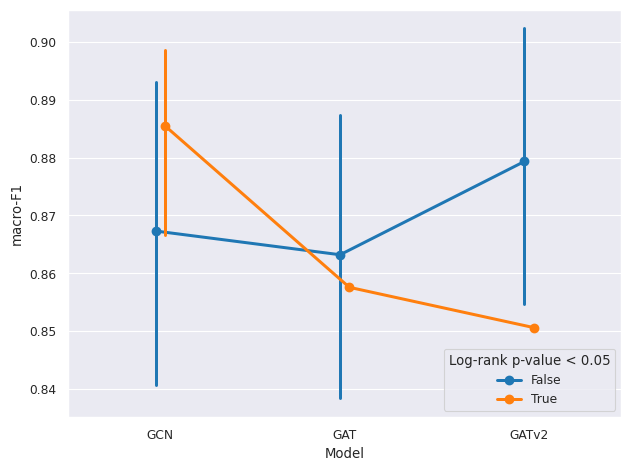

In [14]:
cls_layer = df[df["model"]!="MLP"]
cls_layer["model"] = pd.Categorical(cls_layer["model"], ["GCN", "GAT", "GATv2"])

sns.set_theme(context='paper', style='darkgrid', palette=sns.color_palette("tab10"))

plt.xlabel("Model")
sns.pointplot(data=cls_layer, x="model", y="f1", hue="significant", dodge=True, estimator="mean")

plt.legend(title="Log-rank p-value < 0.05")
plt.ylabel("macro-F1")

plt.tight_layout()
plt.savefig("./plots/model_f1_p_value.png")
plt.show()

In [16]:
df[df["n_edges"]==422]

,model,n_edges,cls_type,finetuned_by,acc,f1,chi,p,test_chi,test_p,significant
15,GCN,422,GNN,chi,0.891089,0.891279,17.457330,0.000569,8.933549,0.030188,True
16,GCN,422,MLP,chi,0.900990,0.898538,17.105124,0.000672,8.970103,0.029691,True
20,GAT,422,GNN,chi,0.891089,0.892965,14.008326,0.002894,7.733763,0.051847,False
14,GAT,422,MLP,chi,0.851485,0.832224,16.976280,0.000715,5.151929,0.161004,False
25,GATv2,422,GNN,chi,0.891089,0.892965,13.535148,0.003611,5.559452,0.135126,False
13,GATv2,422,MLP,chi,0.920792,0.926677,14.793143,0.002002,5.832252,0.120063,False


### Best models

In [8]:
idx = (
    df.groupby("model", observed=True)["f1"].transform("max")
    == df["f1"]
)
best = df[idx]
best

,model,n_edges,cls_type,finetuned_by,acc,f1,chi,p,test_chi,test_p,significant
28,MLP,0,MLP,f1,0.940594,0.949952,10.908020,0.012234,4.601938,0.203376,False
4,GCN,0,GNN,f1,0.920792,0.923163,12.272664,0.006505,6.056904,0.108874,False
19,GAT,0,MLP,f1,0.930693,0.930942,15.409308,0.001498,6.106116,0.106560,False
13,GATv2,422,MLP,f1,0.920792,0.926677,13.627738,0.003458,5.832252,0.120063,False


### Common samples

In [51]:
paths = ["./results/best_chi/MLP_0_MLP/test/predictions.csv", "./results/best_chi/GCN_422_MLP/test/predictions.csv", "./results/best_chi/GAT_5000_MLP/test/predictions.csv", "./results/best_chi/GATv2_5000_GNN/test/predictions.csv"]
# paths = ["./results/best_chi/GCN_422_MLP/test/predictions.csv", "./results/best_chi/GAT_5000_MLP/test/predictions.csv", "./results/best_chi/GATv2_5000_GNN/test/predictions.csv"]
models = ["MLP", "GCN", "GAT", "GATv2"]
# models = ["GCN", "GAT", "GATv2"]
common_samples = surv_data.copy()[test_mask]
temp = surv_data.copy()[test_mask]
for i in range(len(paths)):
    pred = pd.read_csv(paths[i], header=None)[0].astype(int)
    idx = surv_data["class"] != pred
    temp["class"] = pred
    common_samples = pd.merge(common_samples,temp[["Sample_ID","class"]][idx], how="inner", on="Sample_ID", suffixes=(None, models[i]))
common_samples
# common_samples


/tmp/ipykernel_5554/1927312600.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_samples = pd.merge(common_samples,temp[["Sample_ID","class"]][idx], how="inner", on="Sample_ID", suffixes=(None, models[i]))
/tmp/ipykernel_5554/1927312600.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_samples = pd.merge(common_samples,temp[["Sample_ID","class"]][idx], how="inner", on="Sample_ID", suffixes=(None, models[i]))
/tmp/ipykernel_5554/1927312600.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_samples = pd.merge(common_samples,temp[["Sample_ID","class"]][idx], how="inner", on="Sample_ID", suffixes=(None, models[i]))
/tmp/ipykernel_5554/1927312600.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_samples = pd.merge(common_samples,temp[["Sample_ID","class"]][idx], how="inner", on="Sample_ID", suffixes=(None, models[i]))


,Sample_ID,class,Pam50 Subtype,Status,Survival_in_days,Strat_ID,classMLP,classGCN,classGAT,classGATv2
0,AC-A2BM,1,LumB,False,3022,LumB_0,0,0,0,0
1,BH-A0BR,0,LumA,False,2330,LumA_0,3,1,1,1
2,D8-A1X9,0,LumA,False,727,LumA_0,1,1,1,1
3,D8-A1XR,1,LumB,False,482,LumB_0,0,0,0,0
4,E9-A22B,0,LumA,False,1167,LumA_0,1,1,1,1
5,EW-A1J3,0,LumA,False,504,LumA_0,1,1,1,1


# Survival prediction

In [17]:
def combine_surv_results(dict_multiple, dict_test, path, exp_type="test"):

    for id in os.listdir(path):
        print(id)
        if id != "Baseline":
            model, n_edges, cls_type = id.split("_") 
        else:
            model, n_edges, cls_type = ["Baseline", 0, "MLP"]

    
        df_array = (
            pd.read_csv(os.path.join(path, id, exp_type, "surv_results_30.csv"), header=None, index_col=False).values.tolist()
        )

        for row in df_array:
            mtlr_c, mtlr_ibs, coxph_c, coxph_ibs = row
            dict_multiple["model"].append(model)
            dict_multiple["n_edges"].append(int(n_edges) if n_edges != "default" else 422)
            dict_multiple["cls_type"].append(cls_type)
            dict_multiple["C-index"].append(float(mtlr_c))
            dict_multiple["IBS"].append(float(mtlr_ibs))
            dict_multiple["Survival Model"].append(str("MTLR"))

            dict_multiple["model"].append(model)
            dict_multiple["n_edges"].append(int(n_edges) if n_edges != "default" else 422)
            dict_multiple["cls_type"].append(cls_type)
            dict_multiple["C-index"].append(float(coxph_c))
            dict_multiple["IBS"].append(float(coxph_ibs))
            dict_multiple["Survival Model"].append(str("DeepSurv"))

        mtlr_c, mtlr_ibs, coxph_c, coxph_ibs = (
            pd.read_csv(os.path.join(path, id, exp_type, "surv_results_1.csv"), header=None).values.flatten()
        )

        dict_test["model"].append(model)
        dict_test["n_edges"].append(int(n_edges) if n_edges != "default" else 422)
        dict_test["cls_type"].append(cls_type)
        dict_test["CI-MTLR"].append(float(mtlr_c))
        dict_test["IBS-MTLR"].append(float(mtlr_ibs))
        dict_test["CI-DeepSurv"].append(float(coxph_c))
        dict_test["IBS-DeepSurv"].append(float(coxph_ibs))

dict_multiple = {
    "model": [],
    "n_edges": [],
    "cls_type": [],
    "C-index": [],
    "IBS": [],
    "Survival Model": [],
}

dict_test = {
    "model": [],
    "n_edges": [],
    "cls_type": [],
    "CI-MTLR": [],
    "CI-DeepSurv": [],
    "IBS-MTLR": [],
    "IBS-DeepSurv": [],
}

combine_surv_results(dict_multiple,dict_test, "./results/best_models")

GCN_422_MLP
GATv2_5000_GNN
GAT_5000_MLP
Baseline
MLP_0_MLP


In [18]:
df = pd.DataFrame.from_dict(dict_test)
df.to_csv("./surv_test_results.csv")
df["model"] = pd.Categorical(df["model"], ["Baseline", "MLP", "GCN", "GAT", "GATv2"])
df.sort_values("model", inplace=True)
df

,model,n_edges,cls_type,CI-MTLR,CI-DeepSurv,IBS-MTLR,IBS-DeepSurv
3,Baseline,0,MLP,0.745652,0.667391,0.166675,0.185383
4,MLP,0,MLP,0.629348,0.335870,0.184078,0.184415
0,GCN,422,MLP,0.428261,0.641304,0.196400,0.202376
2,GAT,5000,MLP,0.732609,0.463043,0.164866,0.184154
1,GATv2,5000,GNN,0.745652,0.643478,0.164858,0.197762


In [19]:
df = pd.DataFrame.from_dict(dict_multiple)
df.to_csv("./surv_multiple_trials_results.csv")
df["model"] = pd.Categorical(df["model"], ["Baseline", "MLP", "GCN", "GAT", "GATv2"])
df["Survival Model"] = pd.Categorical(df["Survival Model"], ["MTLR", "DeepSurv"])
df.sort_values("model", inplace=True)
df

,model,n_edges,cls_type,C-index,IBS,Survival Model
239,Baseline,0,MLP,0.630357,0.178460,DeepSurv
212,Baseline,0,MLP,0.444130,0.206246,MTLR
213,Baseline,0,MLP,0.620934,0.177002,DeepSurv
214,Baseline,0,MLP,0.697701,0.162249,MTLR
215,Baseline,0,MLP,0.658621,0.177028,DeepSurv
...,...,...,...,...,...,...
83,GATv2,5000,GNN,0.513587,0.177065,DeepSurv
84,GATv2,5000,GNN,0.484211,0.243003,MTLR
85,GATv2,5000,GNN,0.636842,0.198150,DeepSurv
73,GATv2,5000,GNN,0.672185,0.188653,DeepSurv


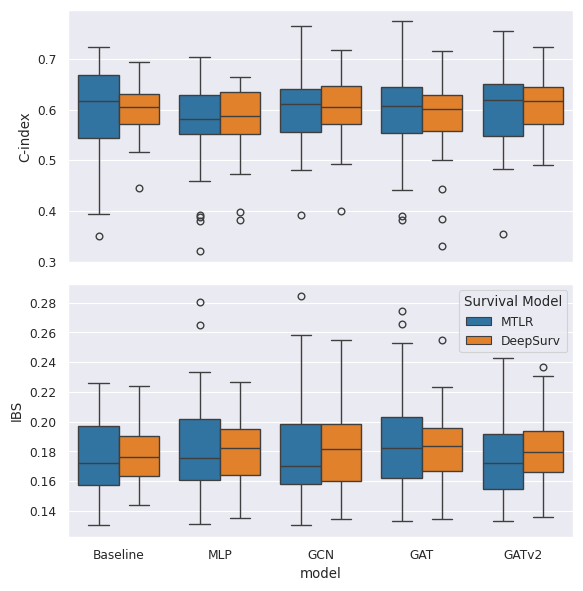

In [20]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), dpi=100, sharex=True)

sns.set_theme(context='paper', style='darkgrid', palette=sns.color_palette("tab10"))

sns.boxplot(df, x="model", y="C-index", hue="Survival Model", ax=axs[0])
sns.boxplot(df, x="model", y="IBS", hue="Survival Model", ax=axs[1])

axs[0].get_legend().remove()

plt.tight_layout()
plt.savefig("./plots/surv_trials.png")
plt.show()